# Bayesian phonon dispersion
Some tests in regards to bayesian phonon dispersions, uncertainity analysis etc.

In [1]:
# Setup plotting, seaborn is just used to make figures look a bit nicer not required
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print('Dont worry')

## Training set

In [2]:
from ase.build import bulk
from hiphive.structure_generation import generate_rattled_structures
from hiphive.utilities import prepare_structures
from ase.calculators.emt import EMT


number_of_structures = 1
cell_size = 4
rattle_std = 0.03

# setup ideal cell
prim = bulk('Ni')
atoms_ideal = bulk('Ni', cubic=True).repeat(cell_size)
calc = EMT()

# generate rattled structures
rattled_structures = generate_rattled_structures(atoms_ideal, number_of_structures, rattle_std)
rattled_structures = prepare_structures(rattled_structures, atoms_ideal, calc)

## Training setup

In [3]:
from hiphive import ClusterSpace, StructureContainer

cutoffs = [6.0]

cs = ClusterSpace(prim, cutoffs)
sc = StructureContainer(cs)
for atoms in rattled_structures:
    sc.add_structure(atoms)

Primitive cell:
    Formula: Ni
    Cell:
        [  0.00000   1.76000   1.76000]
        [  1.76000   0.00000   1.76000]
        [  1.76000   1.76000   0.00000]
    Basis:
        Ni  [  0.00000   0.00000   0.00000]

Crystal symmetry:
    Spacegroup:          Fm-3m (225)
    Unique site:         1
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 6.0
    Found 1 center atom with 78 images totaling 79 atoms

Clusters:
    Clusters: {2: 79}
    Total number of clusters: 79

Orbits:
    Orbits: {2: 6}
    Total number of orbits: 6

Eigentensors:
    Eigentensors: {2: 17}
    Total number of parameters: 17

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 16}
    Total number of degrees of freedom: 16
Done in 0d 0h 0m 20.9s
Done in 0d 0h 0m 3.66s


## Ordinary least-squares fit


In [4]:
import numpy as np
from trainstation import Optimizer

# fit data
A, y = sc.get_fit_data()
n_rows, n_cols = A.shape

opt = Optimizer((A, y), train_size=1.0)
opt.train()
parameters_l2 = opt.parameters
print(opt)

===================== Optimizer ======================
seed                           : 42
fit_method                     : least-squares
standardize                    : True
n_target_values                : 768
n_parameters                   : 16
n_nonzero_parameters           : 16
parameters_norm                : 0.3086727
target_values_std              : 0.3880108
rmse_train                     : 0.03979886
R2_train                       : 0.9894791
AIC                            : -4919.936
BIC                            : -4845.636
train_size                     : 768
test_size                      : 0


## Bayesian parameter optimization and sampling
Here we chose a very simple bayesian sampling approach with simple priors/hyper-priors to demonstrate the idea.

In [5]:
def log_likelihood(A, y_target, dy, theta):
    """
    theta is the solution vector
    """
    y_predicted = np.dot(A, theta)
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + (y_target - y_predicted) ** 2 / dy ** 2)

def log_uniform_prior(theta, theta_max=50000.):
    """
    Return 0 (= log 1, so unnormalized) if all parameters are less than 
    a_max in absolute value, otherwise return -inf (= log 0). 
    """
    if np.all(np.abs(theta) < theta_max):
        return 0
    else:
        return -np.inf

def log_gaussian_prior(theta, std=5.):
    """
    Return a gaussian with width std
    """
    return -0.5 * np.sum(np.log(2 * np.pi * std ** 2) + theta ** 2 / std ** 2)

def log_posterior(theta, A, y, dy, log_prior_func):
    return log_prior_func(theta) + log_likelihood(A, y, dy, theta)


In [6]:
import emcee

# MCMC parameters
dy = 0.04
n_walkers = 40   # number of MCMC walkers
n_steps = 5000  # steps per walker


# sampling
theta_start = parameters_l2 + np.random.normal(0, 0.01, (n_walkers, n_cols))
sampler = emcee.EnsembleSampler(n_walkers, n_cols, log_posterior, 
                                args=[A, y, dy, log_uniform_prior])

sampler.run_mcmc(theta_start, n_steps)
samples_chain = sampler.chain

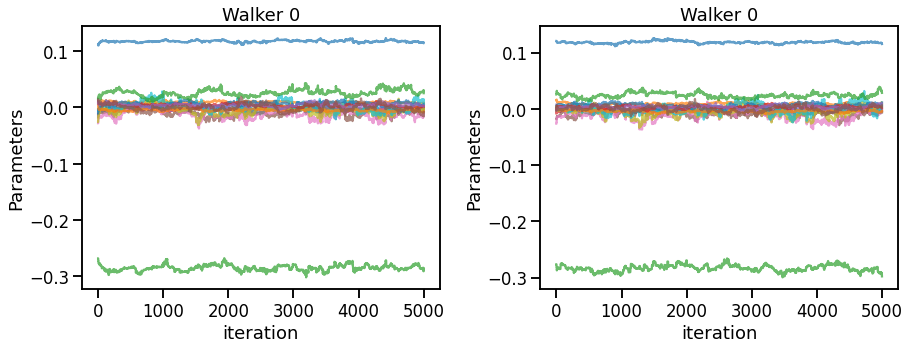

In [7]:
# plot trajectory for single walker

inds = [0, 1]
fig = plt.figure(figsize=(13, 5.2))
for i, ind in enumerate(inds, start=1):
    
    ax1 = fig.add_subplot(1, len(inds), i)
    ax1.plot(samples_chain[ind], alpha=0.7)
    ax1.set_title('Walker 0')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('Parameters')

fig.tight_layout()

(40, 5000, 16)
(160000, 16)


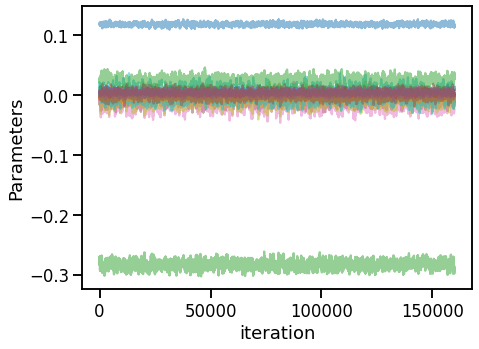

In [8]:
# plot combined samples from all walkers

n_eq = 1000 # number of equilibration steps
samples = samples_chain[:, n_eq:, :].reshape((-1, n_cols))

print(samples_chain.shape)
print(samples.shape)

fig = plt.figure(figsize=(7, 5.2))
plt.plot(samples, alpha=0.5)
plt.xlabel('iteration')
plt.ylabel('Parameters')
fig.tight_layout()

## Calculate phonon dispersion

In [9]:
from hiphive.force_constant_model import ForceConstantModel
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from ase import Atoms


def setup_phonopy(prim, dim):
    atoms_phonopy = PhonopyAtoms(symbols=prim.get_chemical_symbols(),
                                 scaled_positions=prim.get_scaled_positions(),
                                 cell=prim.cell)
    phonopy = Phonopy(atoms_phonopy, supercell_matrix=dim*np.eye(3), primitive_matrix=None)
    return phonopy

def get_phonopy_supercell(prim, dim):
    phonopy = setup_phonopy(prim, dim)
    supercell = phonopy.get_supercell()
    supercell = Atoms(cell=supercell.cell, numbers=supercell.numbers, pbc=True,
                      scaled_positions=supercell.get_scaled_positions())
    return supercell

def get_dispersion(prim,  dim, fcm):
    phonopy = setup_phonopy(prim, dim)
    fcs = fcm.get_force_constants()
    fc2 = fcs.get_fc_array(order=2)
    phonopy.set_force_constants(fc2)
    
    # get phonon dispersion
    phonopy.set_band_structure(bands)
    qvecs, qnorms, freqs, _ = phonopy.get_band_structure()
    q = np.hstack(qnorms)
    f = np.vstack(freqs)
    return q, f
        
def get_band(q_start, q_stop, N):
    """ Return path between q_start and q_stop """
    return np.array([q_start + (q_stop-q_start)*i/(N-1) for i in range(N)])

In [10]:
# phonopy parameters
dim = 5  # dimension in phonopy calculation
Nq = 51  # number of q-points along each segment of the path through the BZ

# setup band path
G2X = get_band(np.array([0, 0, 0]), np.array([0.5, 0.5, 0]), Nq)
X2K2G = get_band(np.array([0.5, 0.5, 1.0]), np.array([0, 0, 0]), Nq)
G2L = get_band(np.array([0, 0, 0]), np.array([0.5, 0.5, 0.5]), Nq)
bands = [G2X, X2K2G, G2L]


qpts = [0.0, 0.2840909090909089, 0.685856125674175, 0.9318860699311174]
qpts_labels = [r'$\Gamma$', 'X', r'$\Gamma$', 'L']

def make_dispersion_nice(ax):
    ax.axvline(x=qpts[1], color='k', lw=1.2, alpha=0.7)
    ax.axvline(x=qpts[2], color='k', lw=1.2, alpha=0.7)
    ax.set_xlabel(r'Wave vector $\vec{q}$')
    ax.set_ylabel(r'Frequency $\omega$ (THz)')
    ax.set_xticks(qpts)
    ax.set_xticklabels(qpts_labels)
    ax.set_xlim([0.0, qpts[-1]])
    ax.set_ylim([0.0, 11.0])

Done in 0d 0h 0m 7.08s


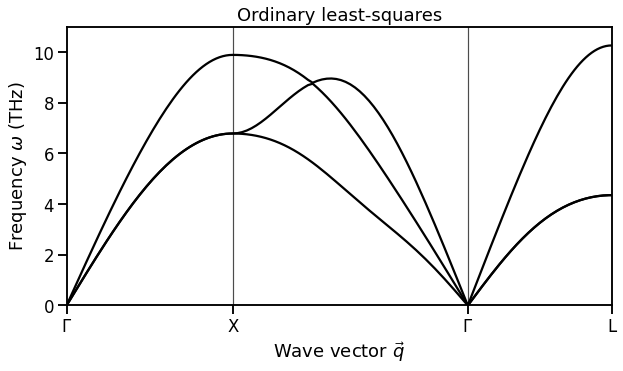

In [11]:
# phonon dispersion from least-square model
supercell= get_phonopy_supercell(prim, dim)
fcm = ForceConstantModel(supercell, cs)
fcm.parameters = parameters_l2
q, f = get_dispersion(prim, dim, fcm)

# plotting
fig = plt.figure(figsize=(9, 5.5))
ax1 = fig.add_subplot(111)
ax1.plot(q, f, '-k')
ax1.set_title('Ordinary least-squares')
make_dispersion_nice(ax1)

fig.tight_layout()

## Bayesian phonon dispersion

In [12]:
# select models from samples
n_models = 200
inds = np.random.choice(samples.shape[0], n_models, replace=False)    
parameter_samples = samples[inds]
print(parameter_samples.shape)


# compute all  dispersions
freqs_all = []
for i, p in enumerate(parameter_samples):
    if i % 25 == 0:
        print('{}/{}'.format(i, n_models))
    
    fcm.parameters = p
    q, f = get_dispersion(prim, dim, fcm)
    freqs_all.append(f)
freqs_all_bayes = np.array(freqs_all)

(200, 16)
0/200
25/200
50/200
75/200
100/200
125/200
150/200
175/200


(200, 153, 3)
(153, 3)
(153, 3)


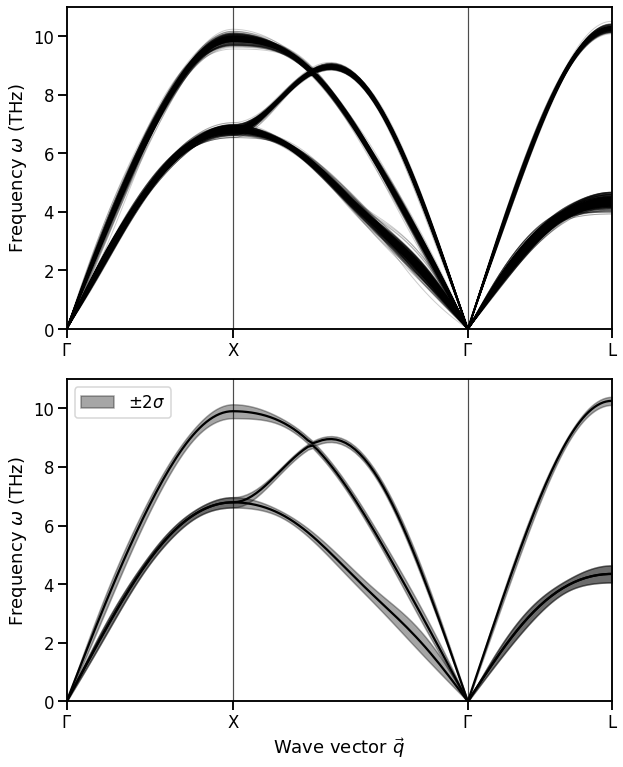

In [13]:
# plot bayesian dispersion
freqs_ave = freqs_all_bayes.mean(axis=0)
freqs_std = freqs_all_bayes.std(axis=0)

print(freqs_all_bayes.shape)
print(freqs_ave.shape)
print(freqs_std.shape)

fig = plt.figure(figsize=(9, 11))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

# plot all dispersions
ax1.plot(q, freqs_ave, '-k')
for f in freqs_all:
    ax1.plot(q, f, '-k', lw=1, alpha=0.2)
make_dispersion_nice(ax1)
ax1.set_xlabel('')

# plot average and std
ax2.plot(q, freqs_ave, '-k')
for i in range(freqs_ave.shape[1]):
    fmin = freqs_ave[:, i] - 2*freqs_std[:, i]
    fmax = freqs_ave[:, i] + 2*freqs_std[:, i]
    line = ax2.fill_between(q, fmin, fmax, color='k', alpha=0.35)
ax2.legend([line], [r'$\pm 2\sigma$'], loc=2)
make_dispersion_nice(ax2)

fig.tight_layout()
fig.savefig('Ni_bayesian_dispersion.svg')

## Bagging phonon dispersion


In [14]:
from trainstation import EnsembleOptimizer

n_models = 200
eopt = EnsembleOptimizer((A, y), ensemble_size=n_models)
eopt.train()

# compute all  dispersions
freqs_all = []
for i, p in enumerate(eopt.parameters_splits):
    if i % 25 == 0:
        print('{}/{}'.format(i, n_models))
    
    fcm.parameters = p
    q, f = get_dispersion(prim, dim, fcm)
    freqs_all.append(f)
freqs_all_bag = np.array(freqs_all)

0/200
25/200
50/200
75/200
100/200
125/200
150/200
175/200


(200, 153, 3)
(153, 3)
(153, 3)


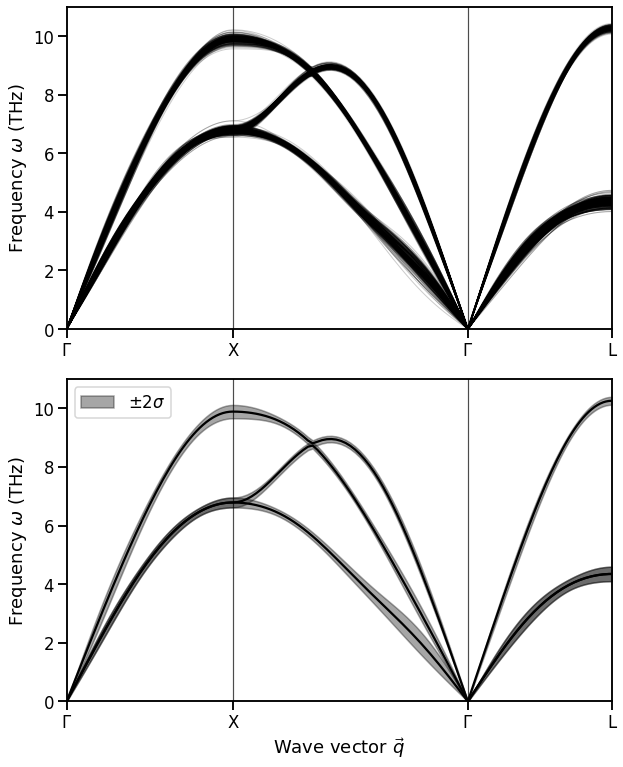

In [15]:
# plot bagging dispersion
freqs_ave = freqs_all_bag.mean(axis=0)
freqs_std = freqs_all_bag.std(axis=0)

print(freqs_all_bag.shape)
print(freqs_ave.shape)
print(freqs_std.shape)

fig = plt.figure(figsize=(9, 11))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

# plot all dispersions
ax1.plot(q, freqs_ave, '-k')
for f in freqs_all:
    ax1.plot(q, f, '-k', lw=1, alpha=0.2)
make_dispersion_nice(ax1)
ax1.set_xlabel('')

# plot average and std
ax2.plot(q, freqs_ave, '-k')
for i in range(freqs_ave.shape[1]):
    fmin = freqs_ave[:, i] - 2*freqs_std[:, i]
    fmax = freqs_ave[:, i] + 2*freqs_std[:, i]
    line = ax2.fill_between(q, fmin, fmax, color='k', alpha=0.35)
ax2.legend([line], [r'$\pm 2\sigma$'], loc=2)
make_dispersion_nice(ax2)

fig.tight_layout()
fig.savefig('Ni_bagging_dispersion.svg')

## Compare Bayesian and bagging
Comparison of the average frequency and uncertainities obtained for the LA, TA1 and TA2 modes using the two methods (Bayesian and Bagging).

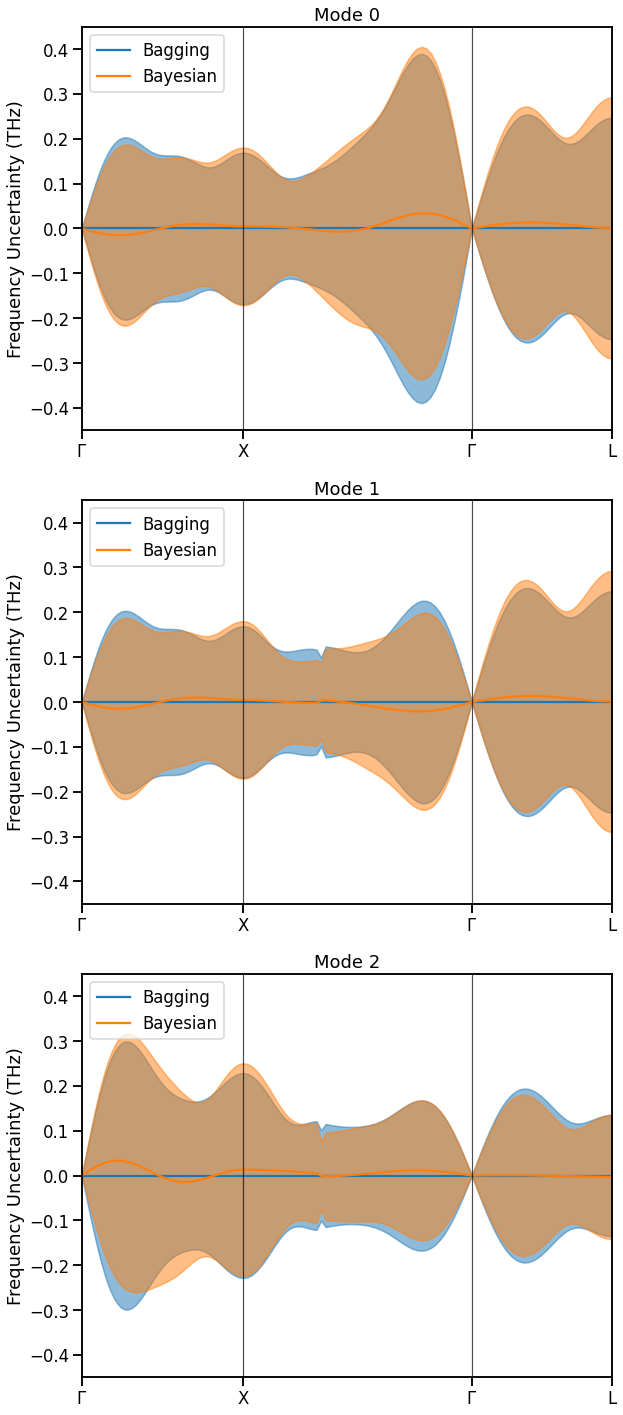

In [16]:
# setup
f1 = freqs_all_bag.mean(axis=0)
f1_std = freqs_all_bag.std(axis=0)

f2 = freqs_all_bayes.mean(axis=0)
f2_std = freqs_all_bayes.std(axis=0)

f_ref = f1

# plot params
col1 = 'tab:blue'
col2 = 'tab:orange'
ylim = [-0.45, 0.45]

fig = plt.figure(figsize=(9, 20))

for i in range(f1.shape[1]): # loop over the 3 modes
    ax = fig.add_subplot(3, 1, i+1)
    plt.plot(q, f1[:, i]-f_ref[:, i], color=col1, label='Bagging')
    plt.plot(q, f2[:, i]-f_ref[:, i], color=col2, label='Bayesian')

    fmin = f1[:, i] - 2*f1_std[:, i] - f_ref[:, i]
    fmax = f1[:, i] + 2*f1_std[:, i] - f_ref[:, i]
    plt.fill_between(q, fmin, fmax, color=col1, alpha=0.5)

    fmin = f2[:, i] - 2*f2_std[:, i] - f_ref[:, i]
    fmax = f2[:, i] + 2*f2_std[:, i] - f_ref[:, i]
    plt.fill_between(q, fmin, fmax, color=col2, alpha=0.5)
    
    plt.legend()
    plt.title('Mode {}'.format(i))
    make_dispersion_nice(ax)
    ax.set_ylim(ylim)
    ax.set_xlabel('')
    plt.ylabel('Frequency Uncertainty (THz)')

    fig.tight_layout()
fig.savefig('Ni_comparison.pdf')